In [1]:
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38617 sha256=29e375d66070508e57bc9940c53c138b18425cc1a1733034205c39ac7b224dd0
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import math
from dataclasses import dataclass
from typing import Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math

In [3]:
# Download and load data
df = yf.download('AMZN',
                 start='2018-05-27',
                 end='2023-05-26',
                 progress=False)
df.to_csv('AMZN.csv')
df = pd.read_csv('AMZN.csv')

# **MAMBA MODEL**

In [4]:
"""

An implementation of the parallel scan operation in PyTorch (Blelloch version).
Please see docs/pscan.ipynb for a detailed explanation of what happens here.

"""

def npo2(len):
    """
    Returns the next power of 2 above len
    """

    return 2 ** math.ceil(math.log2(len))

def pad_npo2(X):
    """
    Pads input length dim to the next power of 2

    Args:
        X : (B, L, D, N)

    Returns:
        Y : (B, npo2(L), D, N)
    """

    len_npo2 = npo2(X.size(1))
    pad_tuple = (0, 0, 0, 0, 0, len_npo2 - X.size(1))
    return F.pad(X, pad_tuple, "constant", 0)

class PScan(torch.autograd.Function):
    @staticmethod
    def pscan(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # modifies X in place by doing a parallel scan.
        # more formally, X will be populated by these values :
        # H[t] = A[t] * H[t-1] + X[t] with H[0] = 0
        # which are computed in parallel (2*log2(T) sequential steps (ideally), instead of T sequential steps)

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :, 1].add_(Aa[:, :, :, 1].mul(Xa[:, :, :, 0]))
            Aa[:, :, :, 1].mul_(Aa[:, :, :, 0])

            Aa = Aa[:, :, :, 1]
            Xa = Xa[:, :, :, 1]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            Aa[:, :, 1].mul_(Aa[:, :, 0])

            Xa[:, :, 3].add_(Aa[:, :, 3].mul(Xa[:, :, 2] + Aa[:, :, 2].mul(Xa[:, :, 1])))
        elif Xa.size(2) == 2:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa = X[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 1]))
        Aa[:, :, 2].mul_(Aa[:, :, 1])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 2**k-1:L:2**k]
            Xa = X[:, :, 2**k-1:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, 1:, 0].add_(Aa[:, :, 1:, 0].mul(Xa[:, :, :-1, 1]))
            Aa[:, :, 1:, 0].mul_(Aa[:, :, :-1, 1])

    @staticmethod
    def pscan_rev(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # the same function as above, but in reverse
        # (if you flip the input, call pscan, then flip the output, you get what this function outputs)
        # it is used in the backward pass

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :, 0].add_(Aa[:, :, :, 0].mul(Xa[:, :, :, 1]))
            Aa[:, :, :, 0].mul_(Aa[:, :, :, 1])

            Aa = Aa[:, :, :, 0]
            Xa = Xa[:, :, :, 0]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 3]))
            Aa[:, :, 2].mul_(Aa[:, :, 3])

            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1].add(Aa[:, :, 1].mul(Xa[:, :, 2]))))
        elif Xa.size(2) == 2:
            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 0:L:2**(num_steps-2)]
        Xa = X[:, :, 0:L:2**(num_steps-2)]
        Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 2]))
        Aa[:, :, 1].mul_(Aa[:, :, 2])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 0:L:2**k]
            Xa = X[:, :, 0:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :-1, 1].add_(Aa[:, :, :-1, 1].mul(Xa[:, :, 1:, 0]))
            Aa[:, :, :-1, 1].mul_(Aa[:, :, 1:, 0])

    @staticmethod
    def forward(ctx, A_in, X_in):
        """
        Applies the parallel scan operation, as defined above. Returns a new tensor.
        If you can, privilege sequence lengths that are powers of two.

        Args:
            A_in : (B, L, D, N)
            X_in : (B, L, D, N)

        Returns:
            H : (B, L, D, N)
        """

        L = X_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            A = A_in.clone()
            X = X_in.clone()
        else:
            # pad tensors (and clone btw)
            A = pad_npo2(A_in) # (B, npo2(L), D, N)
            X = pad_npo2(X_in) # (B, npo2(L), D, N)

        # prepare tensors
        A = A.transpose(2, 1) # (B, D, npo2(L), N)
        X = X.transpose(2, 1) # (B, D, npo2(L), N)

        # parallel scan (modifies X in-place)
        PScan.pscan(A, X)

        ctx.save_for_backward(A_in, X)

        # slice [:, :L] (cut if there was padding)
        return X.transpose(2, 1)[:, :L]

    @staticmethod
    def backward(ctx, grad_output_in):
        """
        Flows the gradient from the output to the input. Returns two new tensors.

        Args:
            ctx : A_in : (B, L, D, N), X : (B, D, L, N)
            grad_output_in : (B, L, D, N)

        Returns:
            gradA : (B, L, D, N), gradX : (B, L, D, N)
        """

        A_in, X = ctx.saved_tensors

        L = grad_output_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            grad_output = grad_output_in.clone()
            # the next padding will clone A_in
        else:
            grad_output = pad_npo2(grad_output_in) # (B, npo2(L), D, N)
            A_in = pad_npo2(A_in) # (B, npo2(L), D, N)

        # prepare tensors
        grad_output = grad_output.transpose(2, 1)
        A_in = A_in.transpose(2, 1) # (B, D, npo2(L), N)
        A = torch.nn.functional.pad(A_in[:, :, 1:], (0, 0, 0, 1)) # (B, D, npo2(L), N) shift 1 to the left (see hand derivation)

        # reverse parallel scan (modifies grad_output in-place)
        PScan.pscan_rev(A, grad_output)

        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_output[:, :, 1:])

        return Q.transpose(2, 1)[:, :L], grad_output.transpose(2, 1)[:, :L]

pscan = PScan.apply

In [5]:
"""

This file closely follows the mamba_simple.py from the official Mamba implementation, and the mamba-minimal by @johnma2006.
The major differences are :
-the convolution is done with torch.nn.Conv1d
-the selective scan is done in PyTorch

A sequential version of the selective scan is also available for comparison.

- A Mamba model is composed of several layers, which are ResidualBlock.
- A ResidualBlock is composed of a MambaBlock, a normalization, and a residual connection : ResidualBlock(x) = mamba(norm(x)) + x
- This leaves us with the MambaBlock : its input x is (B, L, D) and its outputs y is also (B, L, D) (B=batch size, L=seq len, D=model dim).
First, we expand x into (B, L, 2*ED) (where E is usually 2) and split it into x and z, each (B, L, ED).
Then, we apply the short 1d conv to x, followed by an activation function (silu), then the SSM.
We then multiply it by silu(z).
See Figure 3 of the paper (page 8) for a visual representation of a MambaBlock.

"""

@dataclass
class MambaConfig:
    d_model: int # D
    n_layers: int
    dt_rank: Union[int, str] = 'auto'
    d_state: int = 16 # N in paper/comments
    expand_factor: int = 2 # E in paper/comments
    d_conv: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random" # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    bias: bool = False
    conv_bias: bool = True

    pscan: bool = True # use parallel scan mode or sequential mode when training

    def __post_init__(self):
        self.d_inner = self.expand_factor * self.d_model # E*D = ED in comments

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

class Mamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        self.layers = nn.ModuleList([ResidualBlock(config) for _ in range(config.n_layers)])
        #self.norm_f = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        for layer in self.layers:
            x = layer(x)

        #x = self.norm_f(x)

        return x

    def step(self, x, caches):
        # x : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        # y : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])

        return x, caches

class ResidualBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.mixer = MambaBlock(config)
        self.norm = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # output : (B, L, D)

        output = self.mixer(self.norm(x)) + x
        return output

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs: (B, ED, d_conv-1)

        # output : (B, D)
        # cache : (h, inputs)

        output, cache = self.mixer.step(self.norm(x), cache)
        output = output + x
        return output, cache

class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(in_channels=config.d_inner, out_channels=config.d_inner,
                              kernel_size=config.d_conv, bias=config.conv_bias,
                              groups=config.d_inner,
                              padding=config.d_conv - 1)

        # projects x to input-dependent Δ, B, C
        self.x_proj = nn.Linear(config.d_inner, config.dt_rank + 2 * config.d_state, bias=False)

        # projects Δ from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # dt bias
        dt = torch.exp(
            torch.rand(config.d_inner) * (math.log(config.dt_max) - math.log(config.dt_min)) + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        #self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(config.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.D = nn.Parameter(torch.ones(config.d_inner))

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x) # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1) # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2) # (B, ED, L)
        x = self.conv1d(x)[:, :, :L] # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2) # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, L, D)

        return output

    def ssm(self, x):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float()) # (ED, N)
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, L, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, L, ED)

        if self.config.pscan:
            y = self.selective_scan(x, delta, A, B, C, D)
        else:
            y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y

    def selective_scan(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def selective_scan_seq(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)

        hs = torch.stack(hs, dim=1) # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs : (B, ED, d_conv-1)

        # y : (B, D)
        # cache : (h, inputs)

        h, inputs = cache

        xz = self.in_proj(x) # (B, 2*ED)
        x, z = xz.chunk(2, dim=1) # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[:, :, self.config.d_conv-1] # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2) # (B, ED, d_conv-1)
        cache = (h, inputs)

        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(self.A_log.float()) # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, dt_rank), (B, N), (B, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1) # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, ED, N)

        if h is None:
            h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)

        h = deltaA * h + BX # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2) # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        # todo : pq h.squeeze(1) ??
        return y, h.squeeze(1)

# taken straight from https://github.com/johnma2006/mamba-minimal/blob/master/model.py
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()

        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

# **Apply the Mamba Model to our Stock prediction problem**

In [6]:
# 1. Load the preprocessed data
df = pd.read_csv('AMZN.csv')
close_prices = df['Close'].values.reshape(-1, 1)

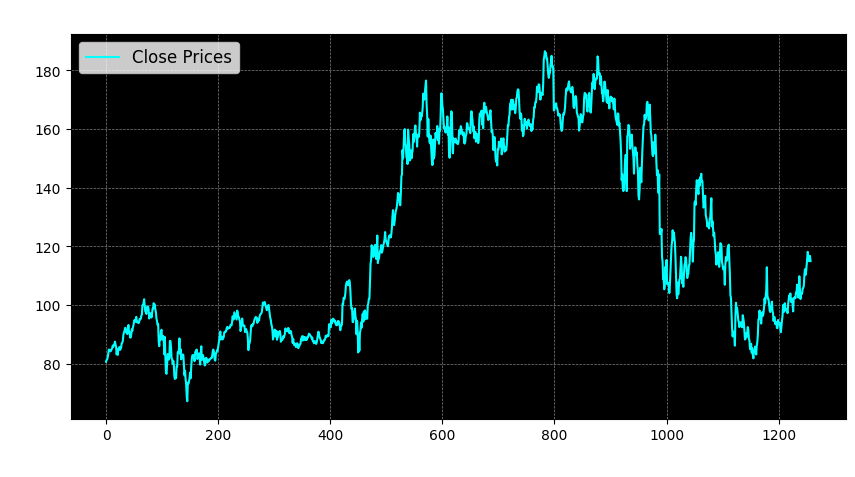

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(close_prices, color='cyan', label='Close Prices')
plt.title('Amazon Stock Close Prices', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time', fontsize=14, color='white')
plt.ylabel('Close Price', fontsize=14, color='white')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Grid
plt.gca().set_facecolor('black')
plt.show()

In [8]:
original_close_prices = close_prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices)

In [9]:
# Split data into train and test sets
training_size = int(len(close_prices) * 0.65)
test_size = len(close_prices) - training_size
train_data, test_data = close_prices[0:training_size, :], close_prices[training_size:len(close_prices), :]

In [10]:
# 2. Function to create dataset
def pre_processing_data(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        features.append(a)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [11]:
time_step = 100
X_train, y_train = pre_processing_data(train_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)

In [12]:
print("X_train")
# print(X_train)
print(X_train.shape)
print("\n")
print("y_train")
# print(y_train)
print(y_train.shape)

print("\n")

print("X_test")
# print(X_test)
print(X_test.shape)
print("\n")
print("y_train")
# print(y_test)
print(y_test.shape)

X_train
(716, 100)


y_train
(716,)


X_test
(340, 100)


y_train
(340,)


In [13]:
# Reshape data for Mamba model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
print("X_train")
# print(X_train)
print(X_train.shape)
print("\n")
print("y_train")
# print(y_train)
print(y_train.shape)

print("\n")

print("X_test")
# print(X_test)
print(X_test.shape)
print("\n")
print("y_train")
# print(y_test)
print(y_test.shape)

X_train
(716, 100, 1)


y_train
(716,)


X_test
(340, 100, 1)


y_train
(340,)


In [15]:
# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [16]:
print("X_train")
# print(X_train)
print(X_train.shape)
print("\n")
print("y_train")
# print(y_train)
print(y_train.shape)

print("\n")

print("X_test")
# print(X_test)
print(X_test.shape)
print("\n")
print("y_train")
# print(y_test)
print(y_test.shape)

X_train
torch.Size([716, 100, 1])


y_train
torch.Size([716])


X_test
torch.Size([340, 100, 1])


y_train
torch.Size([340])


In [57]:
# Define your Mamba configuration
"""
1. `d_model=64`:
   - `d_model` stands for the dimension of the model or the number of channels/features in the model.
   - A value of 64 suggests a moderate-sized model. It's not too small to lose expressive power, but not too large to make training and inference slow or memory-intensive.

2. `n_layers=3`:
   - `n_layers` specifies the number of transformer layers in the model.
   - With 3 layers, the model is kept relatively shallow, which can be beneficial for faster training and inference while still capturing some hierarchical features.

3. `dt_rank='auto'`:
   - `dt_rank` stands for the tensor train rank of the state tensor.
   - Choosing `'auto'` means that the rank is determined automatically based on the other parameters and the problem complexity. This can help in efficiently approximating the high-dimensional tensors in a compressed form.

4. `d_state=16`:
   - `d_state` is the dimensionality of the state tensor.
   - A smaller state dimension reduces the number of parameters and memory usage, making the model more efficient.

5. `expand_factor=2`:
   - `expand_factor` is used to determine the number of output channels in the convolutional layers.
   - An `expand_factor` of 2 means that the number of channels will double in the convolutional layers. This can increase the model's capacity without significantly increasing its size.

6. `d_conv=4`:
   - `d_conv` specifies the number of channels in the convolutional layers.
   - With a small value like 4, the convolutional layers are relatively lightweight, focusing on extracting low-level features.

7. `dt_min=0.001` and `dt_max=0.1`:
   - `dt_min` and `dt_max` define the minimum and maximum values for the time step in the simulation.
   - The chosen range allows for flexibility in adapting to different dynamics in the data.

8. `dt_init="random"`:
   - `dt_init` specifies how the time step is initialized.
   - Random initialization can help in exploring the solution space effectively during training.

9. `dt_scale=1.0`:
   - `dt_scale` scales the time step during training.
   - A scale of 1.0 means no scaling, providing a balanced trade-off between accuracy and stability.

10. `bias=False` and `conv_bias=True`:
   - `bias` determines whether to include bias terms in linear layers.
   - `conv_bias` determines whether to include bias terms in convolutional layers.
   - Excluding biases in linear layers can help reduce the number of parameters, while including biases in convolutional layers can improve the model's capacity to learn from the data.

11. `pscan=True`:
   - `pscan` enables or disables parallel scanning.
   - Parallel scanning can improve the efficiency of the simulation by processing multiple data points simultaneously.

Overall, the chosen configuration aims to strike a balance between model complexity and efficiency, ensuring that the model is capable of capturing relevant features in the data while being practical to train and deploy.
"""
config = MambaConfig(
    d_model=64,
    n_layers=3,
    dt_rank='auto',
    d_state=16,
    expand_factor=2,
    d_conv=4,
    dt_min=0.001,
    dt_max=0.1,
    dt_init="random",
    dt_scale=1.0,
    bias=False,
    conv_bias=True,
    pscan=True
)

# Create the Mamba model
model = Mamba(config)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

Mamba(
  (layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (norm): RMSNorm()
    )
  )
)


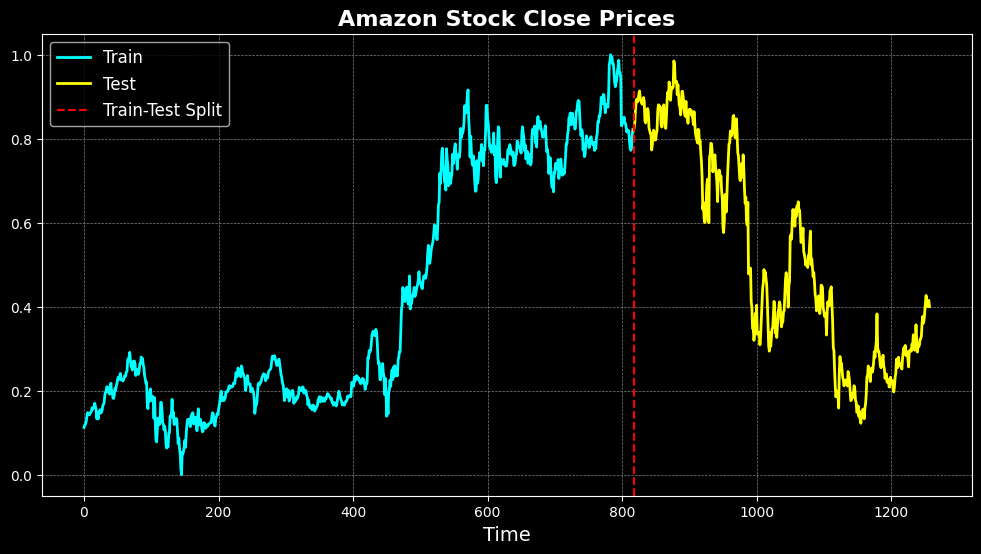

In [74]:
# Plot original close prices with train and test segments in different colors
plt.figure(figsize=(12, 6))

# Plot train data segment
plt.plot(np.arange(0, training_size), close_prices[0:training_size], color='cyan', label='Train', linewidth=2)

# Plot test data segment
plt.plot(np.arange(training_size, len(close_prices)), close_prices[training_size:len(close_prices)], color='yellow', label='Test', linewidth=2)

# Add vertical line to demarcate training and test data
plt.axvline(x=training_size, color='red', linestyle='--', label='Train-Test Split')

plt.title('Amazon Stock Close Prices', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gca().set_facecolor('black')
plt.show()

In [58]:
import math

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_squared_error = 0  # Initialize total squared error

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)

        # Select the last prediction from each sequence in outputs
        last_outputs = outputs[:, -1, -1]

        # Compute the loss
        loss = criterion(last_outputs, batch_y)

        # Compute squared error
        squared_error = torch.square(last_outputs - batch_y).sum().item()
        total_squared_error += squared_error

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    avg_squared_error = total_squared_error / len(train_loader.dataset)
    rmse = math.sqrt(avg_squared_error)  # Calculate RMSE

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Print RMSE for the last epoch
print(f'Train RMSE: {rmse:.4f}')

print("Training completed!")


Epoch [1/10], Loss: 0.0026
Epoch [2/10], Loss: 0.0005
Epoch [3/10], Loss: 0.0004
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0004
Train RMSE: 0.0212
Training completed!


In [59]:
from sklearn.metrics import mean_squared_error
import math

# Create DataLoader for the test dataset
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# Compute loss on the test dataset
total_test_loss = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_x, batch_y in test_loader:

        # Forward pass
        outputs = model(batch_x)

        # Select the last prediction from each sequence in outputs
        last_outputs = outputs[:, -1, -1]

        # Compute the loss
        loss = criterion(last_outputs, batch_y)

        total_test_loss += loss.item()

        # Store predictions and true labels
        all_predictions.extend(last_outputs.cpu().numpy())
        all_true_labels.extend(batch_y.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Compute RMSE
rmse = math.sqrt(mean_squared_error(all_true_labels, all_predictions))
print(f"Test RMSE: {rmse:.4f}")


Test Loss: 0.0010
Test RMSE: 0.0314


In [79]:
# Convert train and test data to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 100, 1)
X_test_tensor = X_test.view(-1, 100, 1)

# Predictions for train and test sets
with torch.no_grad():
    y_train_pred = model(X_train_tensor)[:, -1, -1]
    y_test_pred = model(X_test_tensor)[:, -1, -1]

# Convert predictions to numpy arrays
y_train_pred = y_train_pred.numpy()
y_test_pred = y_test_pred.numpy()

<ipython-input-79-bda7d4a3a586>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 100, 1)


In [80]:
print(y_train_pred.shape)
print(y_test_pred.shape)

(716,)
(340,)


In [81]:
# Assuming y_train_pred is your array with shape (716,)
y_train_pred_reshaped = y_train_pred.reshape(-1, 1)

# Similarly, for y_test_pred
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
# Inverse transform to original form
y_train_pred = scaler.inverse_transform(y_train_pred_reshaped)
y_test_pred = scaler.inverse_transform(y_test_pred_reshaped)

In [82]:
print(y_train_pred.shape)
print(y_test_pred.shape)

(716, 1)
(340, 1)


In [83]:
# Calculate RMSE for train and test predictions
rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Train RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Train RMSE: 126.7967
Test RMSE: 120.1418


(1258, 1)


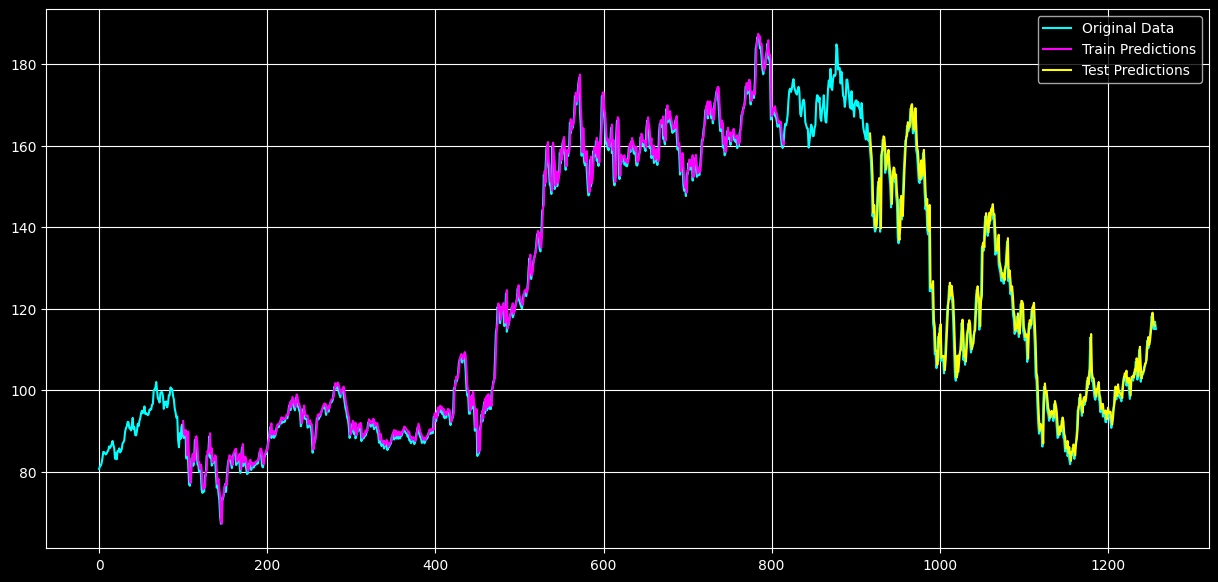

In [65]:
# Define a new window size
window_size = 100

# Initialize arrays for predictions
train_out = np.empty_like(close_prices )
train_out[:, :] = np.nan
print(train_out.shape)
train_out[window_size:len(y_train_pred)+window_size, :] = y_train_pred

test_out = np.empty_like(close_prices )
test_out[:, :] = np.nan
test_out[len(y_train_pred)+(window_size*2)+1:len(close_prices )-1, :] = y_test_pred

# Inverse transform to original scale
close_prices_scaled = scaler.inverse_transform(close_prices .reshape(-1, 1))

# Plot original data and predictions with different colors and background
plt.figure(figsize=(15, 7))
plt.style.use('dark_background')  # Change background to dark
plt.plot(close_prices_scaled, label='Original Data', color='cyan')
plt.plot(train_out, label='Train Predictions', color='magenta')
plt.plot(test_out, label='Test Predictions', color='yellow')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
sample_input = test_data[341:].reshape(1, -1)
temp_input = sample_input.flatten().tolist()

# demonstrate prediction for next 10 days
predictions = []
i = 0
while i < 30:

    if len(temp_input) > 100:
        sample_input = np.array(temp_input[1:])

        # Convert numpy array to PyTorch tensor and reshape
        sample_input = torch.tensor(sample_input, dtype=torch.float32).view(1, -1)
        sample_input = sample_input.view(1, 100, 1)

        # Get prediction from the model
        with torch.no_grad():
            predicted_output = model(sample_input)[:, -1, -1]

        # Convert prediction to list and extend temp_input
        temp_input.extend(np.array([predicted_output.numpy()]).flatten().tolist())
        temp_input = temp_input[1:]

        # Extend lst_output
        predictions.extend(np.array([predicted_output.numpy()]).tolist())

        i = i + 1
    else:
        # Convert temp_input to numpy array, reshape, and convert to tensor
        sample_input = np.array(temp_input).reshape(1, 100, 1)
        sample_input = torch.tensor(sample_input, dtype=torch.float32)

        # Get prediction from the model
        with torch.no_grad():
            predicted_output = model(sample_input)[:, -1, -1]

        print(np.array([predicted_output.numpy()[0]]))

        # Convert prediction to list and extend temp_input
        temp_input.extend(np.array([predicted_output.numpy()]).flatten().tolist())

        # Extend lst_output
        predictions.extend(np.array([predicted_output.numpy()]).tolist())

        i = i + 1
# Limit the output to display only the first 10 predictions
print(predictions)
print(type(predictions))

[0.40732777]
[[0.4073277711868286], [0.4141804575920105], [0.4210221469402313], [0.4279208481311798], [0.43482500314712524], [0.4417358338832855], [0.4486510753631592], [0.45557135343551636], [0.4624963700771332], [0.46942615509033203], [0.4763604998588562], [0.4832994043827057], [0.49024248123168945], [0.4971897602081299], [0.5041412115097046], [0.5110966563224792], [0.5180559158325195], [0.5250189304351807], [0.5319857597351074], [0.538956344127655], [0.5459304451942444], [0.5529079437255859], [0.559889018535614], [0.5668731927871704], [0.5738604664802551], [0.5808506011962891], [0.5878435373306274], [0.5948392152786255], [0.6018373966217041], [0.6088380813598633]]
<class 'list'>


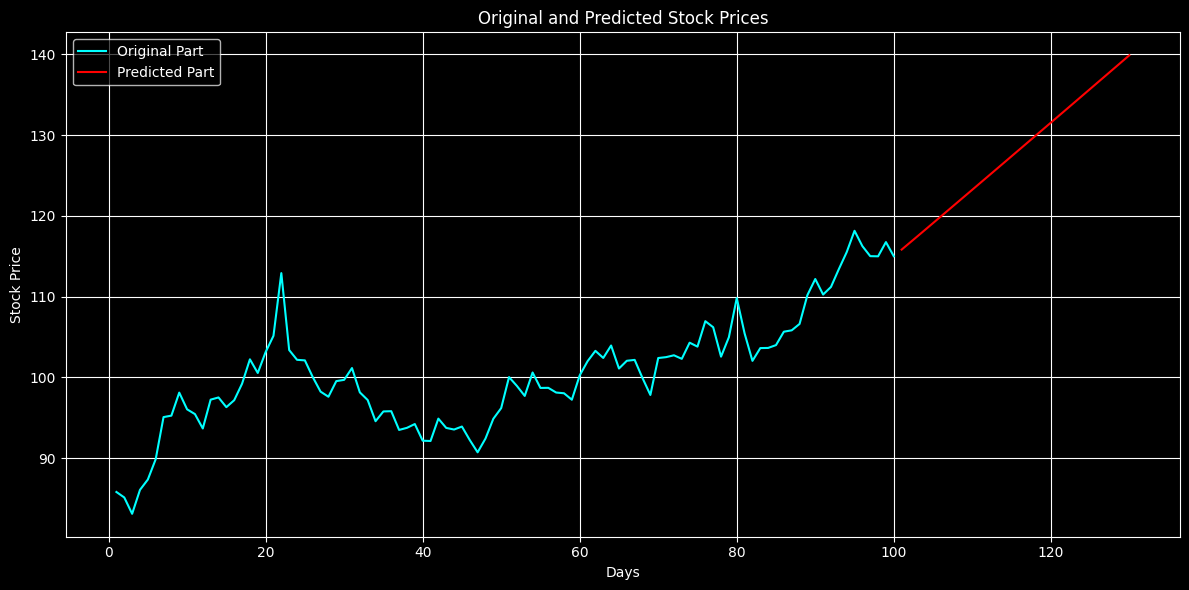

In [67]:
import matplotlib.pyplot as plt

days_original = np.arange(1, 101)
days_predicted = np.arange(101, 131)

plt.figure(figsize=(12, 6))
plt.plot(days_original, scaler.inverse_transform(close_prices[1158:]), label='Original Part', color='cyan')
plt.plot(days_predicted, scaler.inverse_transform(predictions), label='Predicted Part', color='red')

plt.title('Original and Predicted Stock Prices', color='white')
plt.xlabel('Days', color='white')
plt.ylabel('Stock Price', color='white')

plt.grid(True, color='white')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()


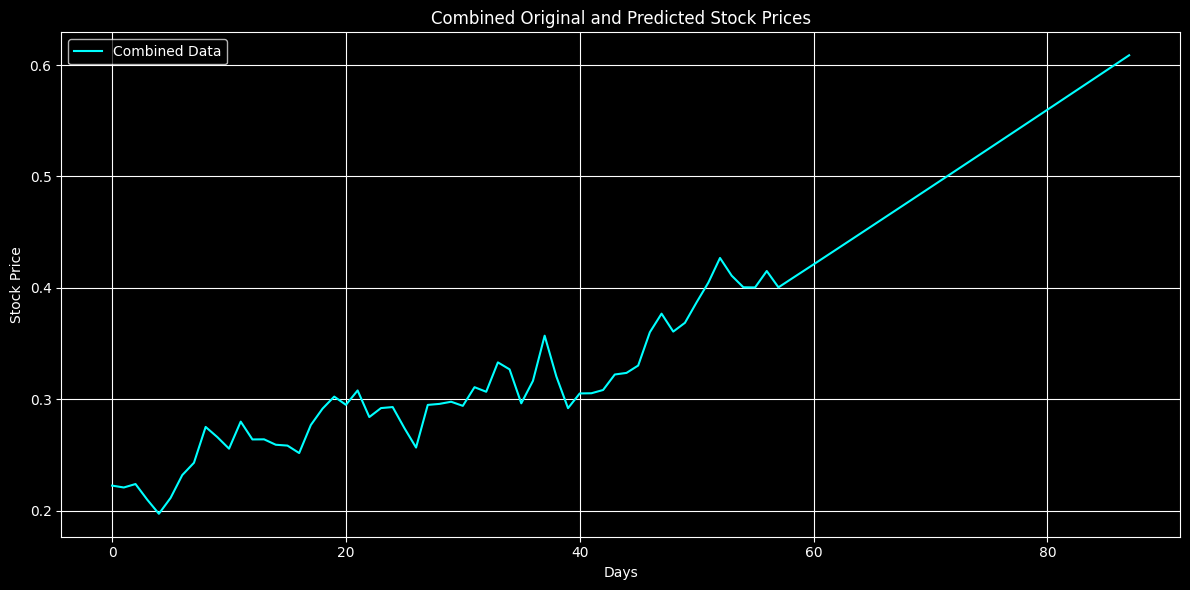

In [68]:
combined_data = close_prices.tolist()
combined_data.extend(predictions)

plt.figure(figsize=(12, 6))
plt.plot(combined_data[1200:], label='Combined Data', color='cyan')
plt.title('Combined Original and Predicted Stock Prices', color='white')
plt.xlabel('Days', color='white')
plt.ylabel('Stock Price', color='white')

plt.grid(True, color='white')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()


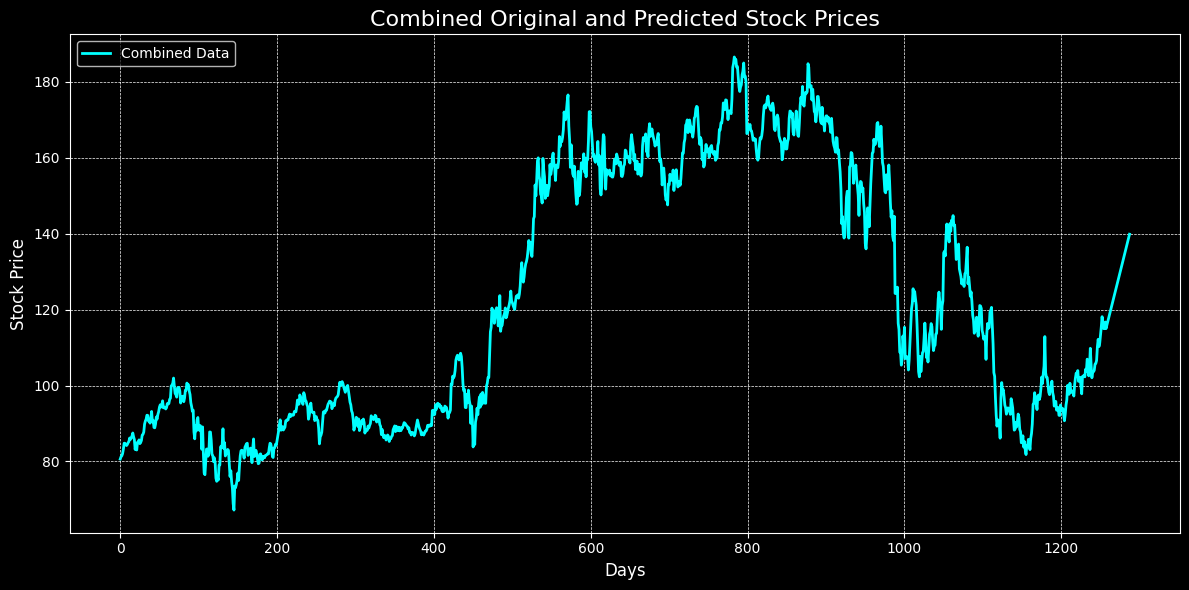

In [69]:
combined_data = scaler.inverse_transform(combined_data).tolist()

plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Combined Data', color='cyan', linewidth=2)

plt.title('Combined Original and Predicted Stock Prices', color='white', fontsize=16)
plt.xlabel('Days', color='white', fontsize=12)
plt.ylabel('Stock Price', color='white', fontsize=12)

plt.grid(True, color='white', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()

In [85]:
# Initialize the total number of parameters
total_params = 0

# Iterate through the model parameters
for param in model.parameters():
    # Increment the total number of parameters
    total_params += param.numel()

# Print the total number of parameters
print("Number of parameters in Mamba model:", total_params)


Number of parameters in Mamba model: 98112
